In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/model_test.zip')
zip_file.extractall('/content/')

In [2]:
import pandas as pd
df=pd.read_csv('model_test.csv')
img_list = ['/content/model_test/' + filename for filename in df['filename']]
label = [0 if lbl == 'happy' else 1 for lbl in df['label']]

In [ ]:
import torch
def load_checkpoint(load_path, model,device):
    checkpoint = torch.load(load_path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

    return checkpoint['epoch'], train_losses, val_losses, train_accuracies, val_accuracies

### test_img(model_weight, img_list): 학습한 모델로 test set 평가
- de, eff, res에 따라 각 모델 구조에 맞는 model weight load
- predictions: 예측된 label 반환
- probabilities: label의 확률 반환

In [ ]:
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image, label
        else:
            return image

def test_img(model_weight,img_list):
  if "de" in model_weight:
    model = models.densenet121(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.features.denseblock4.parameters():
      param.requires_grad = True

    num_classes = 1
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "eff" in model_weight:
    model = models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False

    for param in model.features[5:].parameters():
      param.requires_grad = True
    num_classes = 1
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "res" in model_weight:
    if "18" in model_weight:
      model = models.resnet18(pretrained=True)
    elif "34" in model_weight:
      model = models.resnet34(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.layer4.parameters():
      param.requires_grad = True
    num_classes = 1
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for param in model.fc.parameters():
      param.requires_grad = True

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_checkpoint(model_weight, model, device)

  model.to(device)
  model.eval()

  test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
  ])

  test_dataset = CustomDataset(img_list, labels=None, transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  predictions=[]
  probabilities = []

  with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).long()
        predictions.extend(predicted.cpu().tolist())
        probabilities.extend(probs.cpu().tolist())

  return predictions,probabilities

### resnet34 - sgd, CosineAnnealingWarmRestarts

In [6]:
pred_res34_sgd_cos_b,prob_res34_sgd_cos_b=test_img("res34_sgd_cos_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s]
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possib

### 성능 평가

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def calculate_metrics(label, pred):
  ret=[]
  precision = np.round(precision_score(label, pred),4)
  recall = np.round(recall_score(label, pred),4)
  f1 = np.round(f1_score(label, pred),4)

  print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

  ret.append(precision)
  ret.append(recall)
  ret.append(f1)

  return ret
res34_sgd_cos_b_met=calculate_metrics(label,pred_res34_sgd_cos_b)

Precision: 0.9223, Recall: 0.9694, F1: 0.9453


### 예측 틀린 이미지 시각화

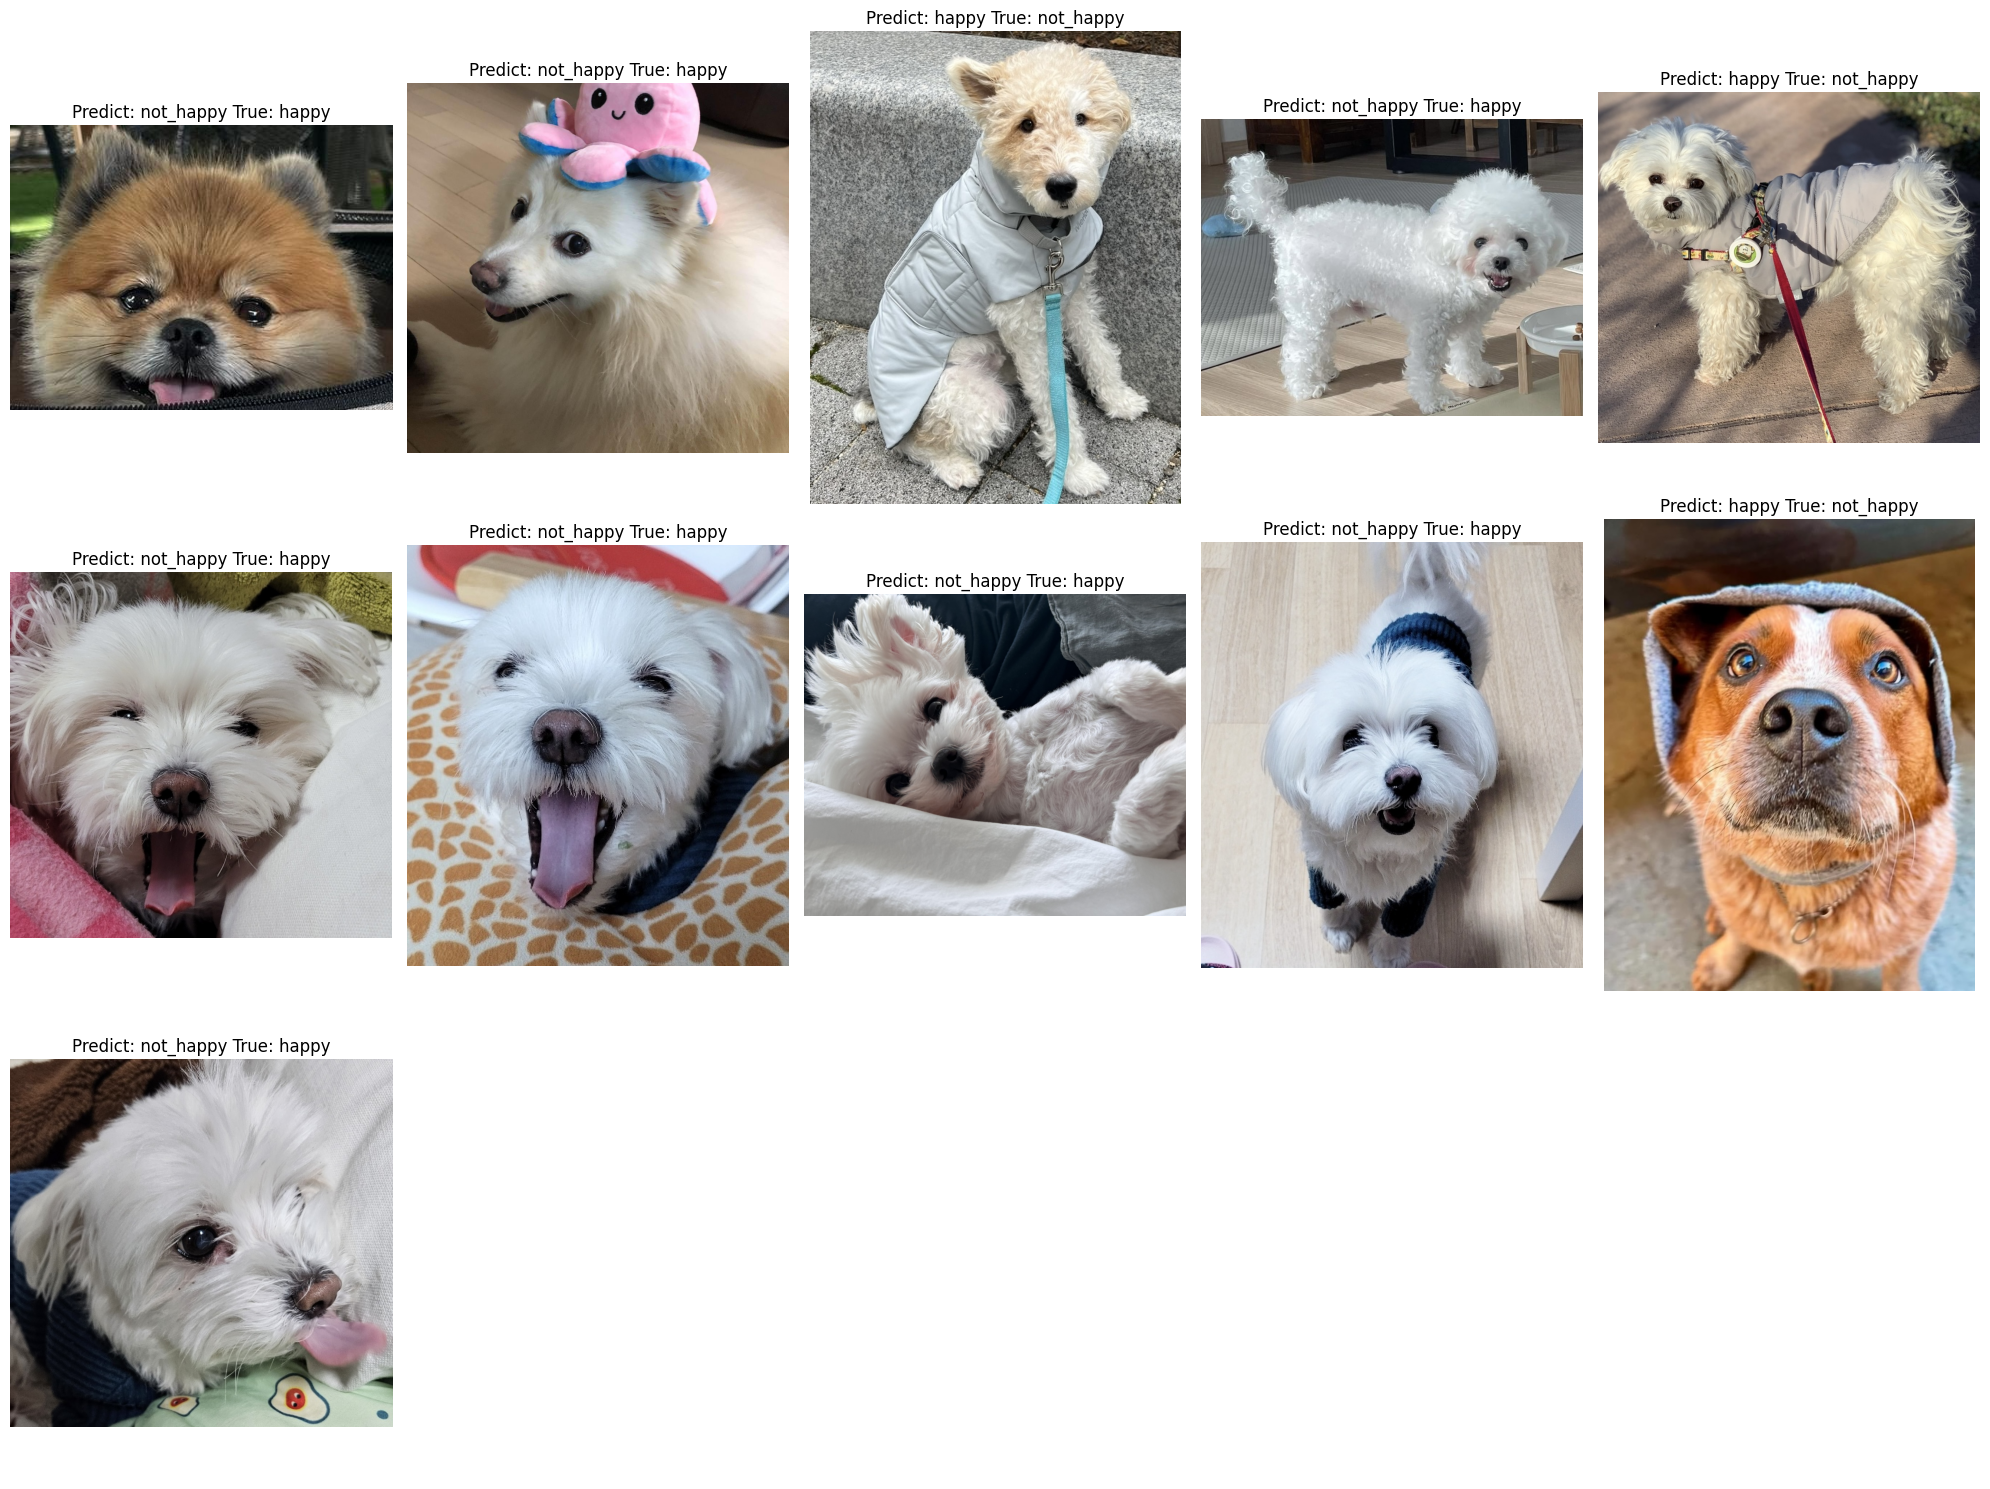

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os


def show_fpred(label,predict,img_list):
  mismatch_indices = [i for i, (true, pred) in enumerate(zip(label, predict)) if true != pred]
  image_list = [img_list[i] for i in mismatch_indices]
  title_texts = [
    f"Predict: {'happy' if predict[i] == 0 else 'not_happy'} True: {'happy' if label[i] == 0 else 'not_happy'}"
    for i in mismatch_indices
  ]

  num_images = len(image_list)
  rows = (num_images + 4) // 5
  fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 5))

  for idx, (img_path, title) in enumerate(zip(image_list, title_texts)):
    img = Image.open(img_path)
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
  for idx in range(len(image_list), rows * 5):
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.axis('off')

  plt.tight_layout()
  plt.show()
  new_image_list = [os.path.basename(path) for path in image_list]
  return new_image_list

mis_res34_sgd_cos_b=show_fpred(label, pred_res34_sgd_cos_b, img_list)

In [9]:
print(mis_res34_sgd_cos_b)

['19.jpg', '42.jpg', '171.jpg', '11.jpg', '108.jpg', '84.jpg', '57.jpg', '91.jpg', '33.jpg', '166.jpg', '77.jpg']


### resnet34 - sgd, CosineAnnealingWarmRestarts (early stopping)

In [10]:
pred_res34_sgd_cos9_b,prob_res34_sgd_cos9_b=test_img("res34_sgd_cos_b_epoch_9.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [11]:
res34_sgd_cos9_b_met=calculate_metrics(label,pred_res34_sgd_cos9_b)

Precision: 0.9314, Recall: 0.9694, F1: 0.95


### resnet34 - AdamW,ReduceLROnPlateau

In [14]:
pred_res34_ada_re_b,prob_res34_ada_re_b=test_img("res34_ada_re_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [15]:
res34_ada_re_b_met=calculate_metrics(label,pred_res34_ada_re_b)

Precision: 0.9412, Recall: 0.9796, F1: 0.96


### resnet34 - AdamW, ReduceLROnPlateau (early stopping)

In [18]:
pred_res34_ada_re8_b,prob_res34_ada_re8_b=test_img("res34_ada_re_b_epoch_8.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [19]:
res34_ada_re8_b_met=calculate_metrics(label,pred_res34_ada_re8_b)

Precision: 0.9505, Recall: 0.9796, F1: 0.9648


### resnet34 - sgd, StepLR

In [22]:
pred_res34_sgd_st_b,prob_res34_sgd_st_b=test_img("res34_sgd_st_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [23]:
res34_sgd_st_b_met=calculate_metrics(label,pred_res34_sgd_st_b)

Precision: 0.9604, Recall: 0.9898, F1: 0.9749


### resnet34 - sgd, StepLR (early stopping)

In [26]:
pred_res34_sgd_st9_b, prob_res34_sgd_st9_b=test_img("res34_sgd_st_b_epoch_9.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [27]:
res34_sgd_st9_b_met=calculate_metrics(label,pred_res34_sgd_st9_b)

Precision: 0.9604, Recall: 0.9898, F1: 0.9749


### resnet34 - sgd

In [30]:
pred_res34_sgd_b, prob_res34_sgd_b=test_img("res34_sgd_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [31]:
res34_sgd_b_met=calculate_metrics(label,pred_res34_sgd_b)

Precision: 0.9327, Recall: 0.9898, F1: 0.9604


### resnet34 - sgd (early stopping)

In [34]:
pred_res34_sgd8_b,prob_res34_sgd8_b=test_img("res34_sgd_b_epoch_8.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [35]:
res34_sgd8_b_met=calculate_metrics(label,pred_res34_sgd8_b)

Precision: 0.9417, Recall: 0.9898, F1: 0.9652


### resnet18 - adamW, ReduceLROnPlateau

In [38]:
pred_res18_ada_re_b,prob_res18_ada_re_b=test_img("res18_ada_re_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.2MB/s]
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

In [39]:
res18_ada_re_b_met=calculate_metrics(label,pred_res18_ada_re_b)

Precision: 0.95, Recall: 0.9694, F1: 0.9596


### resnet18 - AdamW, ReduceLROnPlateau (early stopping)

In [42]:
pred_res18_ada_re10_b,prob_res18_ada_re10_b=test_img("res18_ada_re_b_epoch_10.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [43]:
res18_ada_re10_b_met=calculate_metrics(label,pred_res18_ada_re10_b)

Precision: 0.96, Recall: 0.9796, F1: 0.9697


### resnet18 - sgd, CosineAnnealingWarmRestarts

In [46]:
pred_res18_sgd_cos_b,prob_res18_sgd_cos_b=test_img("res18_sgd_cos_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [47]:
res18_sgd_cos_b_met=calculate_metrics(label,pred_res18_sgd_cos_b)

Precision: 0.8889, Recall: 0.9796, F1: 0.932


### resnet18 - sgd, CosineAnnealingWarmRestarts (early stopping)

In [50]:
pred_res18_sgd_cos9_b,prob_res18_sgd_cos9_b=test_img("res18_sgd_cos_b_epoch_9.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-4-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [51]:
res18_sgd_cos9_b_met=calculate_metrics(label,pred_res18_sgd_cos9_b)

Precision: 0.9223, Recall: 0.9694, F1: 0.9453


### 데이터프레임으로

In [54]:
data = [
    {"filename": " res34_sgd_cos_b_met", "precision":  res34_sgd_cos_b_met[0], "recall":  res34_sgd_cos_b_met[1], "f1":  res34_sgd_cos_b_met[2]},
    {"filename": " res34_sgd_cos9_b_met ", "precision":  res34_sgd_cos9_b_met [0], "recall":  res34_sgd_cos9_b_met [1], "f1":  res34_sgd_cos9_b_met [2]},
    {"filename": "res34_ada_re_b_met", "precision": res34_ada_re_b_met[0], "recall": res34_ada_re_b_met[1], "f1": res34_ada_re_b_met[2]},
    {"filename": "res34_ada_re8_b_met", "precision": res34_ada_re8_b_met[0], "recall": res34_ada_re8_b_met[1], "f1": res34_ada_re8_b_met[2]},
    {"filename": " res34_sgd_st_b_met", "precision":  res34_sgd_st_b_met[0], "recall":  res34_sgd_st_b_met[1], "f1":  res34_sgd_st_b_met[2]},
    {"filename": " res34_sgd_st9_b_met ", "precision":  res34_sgd_st9_b_met [0], "recall":  res34_sgd_st9_b_met [1], "f1":  res34_sgd_st9_b_met [2]},
    {"filename": "res34_sgd_b_met", "precision": res34_sgd_b_met[0], "recall": res34_sgd_b_met[1], "f1": res34_sgd_b_met[2]},
    {"filename": " res34_sgd8_b_met", "precision":  res34_sgd8_b_met[0], "recall":  res34_sgd8_b_met[1], "f1":  res34_sgd8_b_met[2]},
    {"filename": "res18_ada_re_b_met", "precision": res18_ada_re_b_met[0], "recall": res18_ada_re_b_met[1], "f1": res18_ada_re_b_met[2]},
    {"filename": " res18_ada_re10_b_met", "precision":  res18_ada_re10_b_met[0], "recall":  res18_ada_re10_b_met[1], "f1":  res18_ada_re10_b_met[2]},
    {"filename": " res18_sgd_cos_b_met ", "precision":  res18_sgd_cos_b_met [0], "recall":  res18_sgd_cos_b_met [1], "f1":  res18_sgd_cos_b_met [2]},
    {"filename": "res18_sgd_cos9_b_met", "precision": res18_sgd_cos9_b_met[0], "recall": res18_sgd_cos9_b_met[1], "f1": res18_sgd_cos9_b_met[2]}
]

df = pd.DataFrame(data)

In [55]:
df.to_csv('resnet_metrics_new.csv', index=False)

In [60]:
df_prob = pd.DataFrame({
    'prob_res34_sgd_cos_b': pd.Series(prob_res34_sgd_cos_b),
    'prob_res34_sgd_cos9_b': pd.Series(prob_res34_sgd_cos9_b),
    'prob_res34_ada_re_b': pd.Series(prob_res34_ada_re_b),
    'prob_res34_ada_re8_b': pd.Series(prob_res34_ada_re8_b),
    'prob_res34_sgd_st_b': pd.Series(prob_res34_sgd_st_b),
    'prob_res34_sgd_st9_b': pd.Series(prob_res34_sgd_st9_b),
    'prob_res34_sgd_b': pd.Series(prob_res34_sgd_b),
    'prob_res34_sgd8_b': pd.Series(prob_res34_sgd8_b),
    'prob_res18_ada_re_b': pd.Series(prob_res18_ada_re_b),
    'prob_res18_ada_re10_b': pd.Series(prob_res18_ada_re10_b),
    'prob_res18_sgd_cos_b': pd.Series(prob_res18_sgd_cos_b),
    'prob_res18_sgd_cos9_b': pd.Series(prob_res18_sgd_cos9_b)
})

In [61]:
for i in range(len(label)):
  if label[i]==0:label[i]='happy'
  else:label[i]='not_happy'

In [63]:
df_prob['label']=label

In [65]:
img_list = [os.path.basename(path) for path in img_list]

In [66]:
df_prob.insert(0, 'img_list', img_list)

In [67]:
df_prob.head()

,img_list,prob_res34_sgd_cos_b,prob_res34_sgd_cos9_b,prob_res34_ada_re_b,prob_res34_ada_re8_b,prob_res34_sgd_st_b,prob_res34_sgd_st9_b,prob_res34_sgd_b,prob_res34_sgd8_b,prob_res18_ada_re_b,prob_res18_ada_re10_b,prob_res18_sgd_cos_b,prob_res18_sgd_cos9_b,label
0,172.jpg,0.996161,0.940161,0.992262,0.971370,0.934526,0.873283,0.974690,0.975641,0.904081,0.904576,0.993358,0.825286,not_happy
1,190.jpg,0.996620,0.982475,0.995723,0.993929,0.971204,0.965639,0.999998,0.996081,0.888692,0.866858,0.442210,0.586973,not_happy
2,60.jpg,0.004151,0.003173,0.002490,0.003274,0.009115,0.018360,0.019758,0.000989,0.010340,0.012727,0.021166,0.014148,happy
3,229.jpg,0.999332,0.999970,0.999744,0.999726,0.999683,0.999187,0.999998,0.999971,0.999904,0.999806,0.999136,0.999846,not_happy
4,183.jpg,0.997407,0.998314,0.997552,0.996623,0.996335,0.994723,0.999999,0.996836,0.976982,0.988997,0.997425,0.967058,not_happy


In [68]:
df_prob.to_csv('resnet_probability_new.csv', index=False)